## Exercise 6: Shared utility functions, data catalogs

Skills: 
* Import shared utils
* Data catalog
* Use functions to repeat certain data cleaning steps

References: 
* https://docs.calitp.org/data-infra/analytics_new_analysts/02-data-analysis-intermediate.html
* https://docs.calitp.org/data-infra/analytics_tools/python_libraries.html
* https://docs.calitp.org/data-infra/analytics_tools/data_catalogs.html

In [1]:
import geopandas as gpd
import intake
import pandas as pd

# Hint: if this doesn't import: refer to docs for correctly import
# cd into _shared_utils folder, run the make setup_env command
import shared_utils

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_733/3432162632.py:1: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling P

## Create a data catalog

* Include one geospatial data source and one tabular (they should be related...your analysis depends on combining them)
* Import your datasets using the catalog method

In [5]:
#catalog. see `christian_ex6_catalog.yml' file
#code sample: catalog = intake.open_catalog("./sample-catalog.yml")

catalog = intake.open_catalog("./christian_ex6_catalog.yml")

catalog

christian_ex6_catalog:
  args:
    path: ./christian_ex6_catalog.yml
  description: ''
  driver: intake.catalog.local.YAMLFileCatalog
  metadata:
    version: 1


In [6]:
#importing datasets using intake catalog
stops = catalog.stops.read()
ca_county = catalog.ca_counties.read()


## Combine datasets
* Do a merge or spatial join to combine the geospatial and tabular data
* Create a new column of a summary statistic to visualize
* Rely on `shared_utils` to do at least one operation (aggregation, re-projecting to a different CRS, exporting geoparquet, etc)

In [7]:
stops.head()

,Unnamed: 0,feed_key,stop_id,stop_lat,stop_lon,stop_name
0,0,25c6505166c01099b2f6f2de173e20b9,22nd_street,37.756972,-122.392492,22nd Street
1,1,25c6505166c01099b2f6f2de173e20b9,2537740,37.438491,-122.156405,Stanford Caltrain Station
2,2,25c6505166c01099b2f6f2de173e20b9,2537744,37.438425,-122.156482,Stanford Caltrain Station
3,3,25c6505166c01099b2f6f2de173e20b9,70011,37.776390,-122.394992,San Francisco Caltrain Station
4,4,25c6505166c01099b2f6f2de173e20b9,70012,37.776348,-122.394935,San Francisco Caltrain Station


In [7]:
ca_county.head()

,OBJECTID,COUNTY_NAME,COUNTY_ABBREV,COUNTY_NUM,COUNTY_CODE,COUNTY_FIPS,ISLAND,GlobalID,SHAPE_Length,SHAPE_Area,geometry
0,1,Alameda,ALA,1,01,001,NaN,{E6F92268-D2DD-4CFB-8B79-5B4B2F07C559},2.538264,0.217411,"MULTIPOLYGON (((-122.27125 37.90503, -122.2702..."
1,2,Alpine,ALP,2,02,003,NaN,{870479B2-480A-494B-8352-AD60578839C1},2.170420,0.198471,"MULTIPOLYGON (((-119.58667 38.71420, -119.5865..."
2,3,Amador,AMA,3,03,005,NaN,{4F45B3A6-BE10-461C-8945-6B2AAA7119F6},2.924268,0.161961,"MULTIPOLYGON (((-120.07246 38.70276, -120.0724..."
3,4,Butte,BUT,4,04,007,NaN,{44FBA680-AECC-4E04-A499-29D69AFFBD4A},4.210365,0.455899,"MULTIPOLYGON (((-121.07661 39.59729, -121.0794..."
4,5,Calaveras,CAL,5,05,009,NaN,{D11EF739-4A1E-414E-BFD1-E7DCD56CD61E},2.989673,0.275908,"MULTIPOLYGON (((-120.01792 38.43586, -120.0178..."


### Method

for `stops`
* drop unnessary column
* used shared utils to turn into point geometry and set crs to 2229

For `ca_county` 
* assign crs to 2229

for sjoin
* ensure geometry col for stops and county are the same
* put county on left, join using inner


In [15]:
#drop unnamed col from stops

stops = stops.drop(columns=['Unnamed: 0'], axis=1)
stops.head()

,feed_key,stop_id,stop_lat,stop_lon,stop_name
0,25c6505166c01099b2f6f2de173e20b9,22nd_street,37.756972,-122.392492,22nd Street
1,25c6505166c01099b2f6f2de173e20b9,2537740,37.438491,-122.156405,Stanford Caltrain Station
2,25c6505166c01099b2f6f2de173e20b9,2537744,37.438425,-122.156482,Stanford Caltrain Station
3,25c6505166c01099b2f6f2de173e20b9,70011,37.776390,-122.394992,San Francisco Caltrain Station
4,25c6505166c01099b2f6f2de173e20b9,70012,37.776348,-122.394935,San Francisco Caltrain Station


In [19]:
#use share_utils to create point geometry, check for gdf status
#stops_ptg = geography_utils.create_point_geometry(
#    stops_gdf,
#    "stop_lon",
#    "stop_lat",
#    crs = "EPSG:2229"
#)

from shared_utils import geography_utils

stops_ptg = geography_utils.create_point_geometry(
    stops,
    'stop_lon',
    'stop_lat',
    crs = 'EPSG:2229'
)
stops_ptg.head()

,feed_key,stop_id,stop_lat,stop_lon,stop_name,geometry
0,25c6505166c01099b2f6f2de173e20b9,22nd_street,37.756972,-122.392492,22nd Street,POINT (5290484.166 3218221.779)
1,25c6505166c01099b2f6f2de173e20b9,2537740,37.438491,-122.156405,Stanford Caltrain Station,POINT (5353967.719 3099309.691)
2,25c6505166c01099b2f6f2de173e20b9,2537744,37.438425,-122.156482,Stanford Caltrain Station,POINT (5353944.533 3099286.476)
3,25c6505166c01099b2f6f2de173e20b9,70011,37.776390,-122.394992,San Francisco Caltrain Station,POINT (5290070.611 3225326.968)
4,25c6505166c01099b2f6f2de173e20b9,70012,37.776348,-122.394935,San Francisco Caltrain Station,POINT (5290086.422 3225310.947)


In [21]:
type(stops_ptg)

geopandas.geodataframe.GeoDataFrame

In [22]:
stops_ptg.crs

<Projected CRS: EPSG:2229>
Name: NAD83 / California zone 5 (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - California - counties Kern; Los Angeles; San Bernardino; San Luis Obispo; Santa Barbara; Ventura.
- bounds: (-121.42, 32.76, -114.12, 35.81)
Coordinate Operation:
- name: SPCS83 California zone 5 (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [23]:
#not look at ca_county
type(ca_county)

geopandas.geodataframe.GeoDataFrame

In [24]:
#current CRS set to EPGS 4326
ca_county.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [27]:
#test to set CRS to another 2229
county2229 = ca_county.to_crs('EPSG:2229')

In [29]:
#crs now set to 2229
county2229.crs

<Projected CRS: EPSG:2229>
Name: NAD83 / California zone 5 (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - California - counties Kern; Los Angeles; San Bernardino; San Luis Obispo; Santa Barbara; Ventura.
- bounds: (-121.42, 32.76, -114.12, 35.81)
Coordinate Operation:
- name: SPCS83 California zone 5 (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [30]:
#checking columns to see what we got
county2229.head()

#noticed that county2229 geometry column is now a multpolygon. expecting sjoin not to work

,OBJECTID,COUNTY_NAME,COUNTY_ABBREV,COUNTY_NUM,COUNTY_CODE,COUNTY_FIPS,ISLAND,GlobalID,SHAPE_Length,SHAPE_Area,geometry
0,1,Alameda,ALA,1,01,001,NaN,{E6F92268-D2DD-4CFB-8B79-5B4B2F07C559},2.538264,0.217411,"MULTIPOLYGON (((5327843.636 3270649.517, 53281..."
1,2,Alpine,ALP,2,02,003,NaN,{870479B2-480A-494B-8352-AD60578839C1},2.170420,0.198471,"MULTIPOLYGON (((6107872.113 3543254.346, 61079..."
2,3,Amador,AMA,3,03,005,NaN,{4F45B3A6-BE10-461C-8945-6B2AAA7119F6},2.924268,0.161961,"MULTIPOLYGON (((5968863.196 3541606.326, 59687..."
3,4,Butte,BUT,4,04,007,NaN,{44FBA680-AECC-4E04-A499-29D69AFFBD4A},4.210365,0.455899,"MULTIPOLYGON (((5691714.322 3875581.366, 56907..."
4,5,Calaveras,CAL,5,05,009,NaN,{D11EF739-4A1E-414E-BFD1-E7DCD56CD61E},2.989673,0.275908,"MULTIPOLYGON (((5982508.552 3443893.703, 59825..."


In [31]:
stops_ptg.head()
#see that geometry column is in point. byt numbers inside look correct

,feed_key,stop_id,stop_lat,stop_lon,stop_name,geometry
0,25c6505166c01099b2f6f2de173e20b9,22nd_street,37.756972,-122.392492,22nd Street,POINT (5290484.166 3218221.779)
1,25c6505166c01099b2f6f2de173e20b9,2537740,37.438491,-122.156405,Stanford Caltrain Station,POINT (5353967.719 3099309.691)
2,25c6505166c01099b2f6f2de173e20b9,2537744,37.438425,-122.156482,Stanford Caltrain Station,POINT (5353944.533 3099286.476)
3,25c6505166c01099b2f6f2de173e20b9,70011,37.776390,-122.394992,San Francisco Caltrain Station,POINT (5290070.611 3225326.968)
4,25c6505166c01099b2f6f2de173e20b9,70012,37.776348,-122.394935,San Francisco Caltrain Station,POINT (5290086.422 3225310.947)


In [36]:
#test of spatial join
sjoin = gpd.sjoin(county2229, stops_ptg, how='inner')

sjoin.head()
#join worked any produced something

,OBJECTID,COUNTY_NAME,COUNTY_ABBREV,COUNTY_NUM,COUNTY_CODE,COUNTY_FIPS,ISLAND,GlobalID,SHAPE_Length,SHAPE_Area,geometry,index_right,feed_key,stop_id,stop_lat,stop_lon,stop_name
23,24,Merced,MER,24,24,047,NaN,{F3D6231C-C7FA-4340-B03F-23C1D0572979},3.556687,0.519787,"MULTIPOLYGON (((5874128.469 3143301.015, 58787...",566,52639f09eb535f75b33d2c6a654cb89e,782479,36.964503,-120.653529,Kwik Serv (South Dos Palos)
23,24,Merced,MER,24,24,047,NaN,{F3D6231C-C7FA-4340-B03F-23C1D0572979},3.556687,0.519787,"MULTIPOLYGON (((5874128.469 3143301.015, 58787...",505,52639f09eb535f75b33d2c6a654cb89e,768637,36.964522,-120.653626,Dos Palos/Chics Market
23,24,Merced,MER,24,24,047,NaN,{F3D6231C-C7FA-4340-B03F-23C1D0572979},3.556687,0.519787,"MULTIPOLYGON (((5874128.469 3143301.015, 58787...",252,52639f09eb535f75b33d2c6a654cb89e,768356,36.964552,-120.653486,Dos Palos/Chics Market (to Los Banos)
23,24,Merced,MER,24,24,047,NaN,{F3D6231C-C7FA-4340-B03F-23C1D0572979},3.556687,0.519787,"MULTIPOLYGON (((5874128.469 3143301.015, 58787...",568,52639f09eb535f75b33d2c6a654cb89e,782481,36.968538,-120.644763,South Dos Palos County Park
23,24,Merced,MER,24,24,047,NaN,{F3D6231C-C7FA-4340-B03F-23C1D0572979},3.556687,0.519787,"MULTIPOLYGON (((5874128.469 3143301.015, 58787...",567,52639f09eb535f75b33d2c6a654cb89e,782480,36.968476,-120.653701,Lexington Ave Stop


In [35]:
#checking to see what sjoin looks like
print(sjoin.shape)
print(sjoin.OBJECTID.notna().value_counts())
print(sjoin.feed_key.notna().value_counts())

(580, 17)
True    580
Name: OBJECTID, dtype: int64
True    580
Name: feed_key, dtype: int64


<AxesSubplot:>

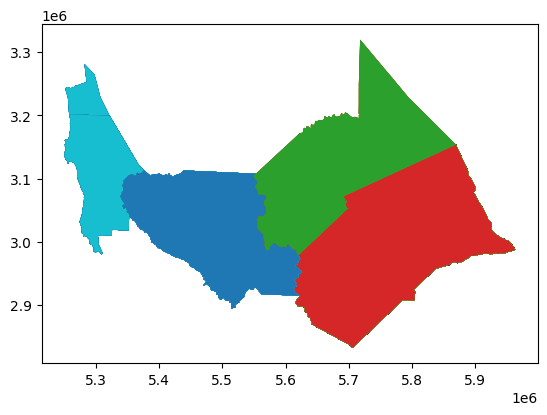

In [44]:
#checking to see if sjoin plots anything

sjoin.plot('stop_id')

#sjoin plots something

In [ ]:
#testing what explore() looks like

#TAKES A LONG TIME TO RUN, AND MAKES LOCAL SAVING FAIL.

sjoin.explore('COUNTY_NAME')

## Use functions to do parameterized visualizations
* Use a function to create your chart
* Within the function, the colors should use the Cal-ITP theme that is available in `styleguide`
* Within the function, there should be at least 1 parameter that changes (ex: chart title reflects the correct county, legend title reflects the correct county, etc)|
* Produce 3 charts, using your function each time, and have the function correctly insert the parameters 